In [1]:
%load_ext watermark
%matplotlib inline

In [2]:
import datetime
import iris
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import numpy as np
import os
import string
#
import umtools.irismode as umi
import umtools.utils as umu
from faamtools.core import parse_profiles_runs_info, read_core_nc
import pyveccalc.iris_api as pvci
#
import map_plot_func as mymap
import mypaths
import plot_params as pp
import misc_utils as misc

In [3]:
%watermark -u -d -m -v -p numpy,matplotlib,iris,sattools,umtools,faamtools,pyveccalc

last updated: 2016-08-16 

CPython 3.5.2
IPython 5.0.0

numpy 1.10.4
matplotlib 1.5.2
iris 1.9.2
sattools 0.1
umtools 0.1.5
faamtools 0.2.3
pyveccalc 0.2.8

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 3.13.0-93-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [4]:
mpl.rcParams['mathtext.default'] = 'regular'
mpl.rcParams['font.family'] = 'sans-serif'

In [5]:
uchar_list = list(string.ascii_uppercase)
lchar_list = list(string.ascii_lowercase)

In [6]:
pe = [PathEffects.withStroke(linewidth=1, foreground='K')]

In [7]:
iris.FUTURE.netcdf_promote = True
iris.FUTURE.cell_datetime_objects = True
um_res = umu.grdstep('km2p2')
fcst_init = '25_1200'

In [8]:
fcst_init_dt = datetime.datetime.strptime('201303'+fcst_init, '%Y%m%d_%H%M')

In [9]:
fmt = 'pdf'
svfigkw = dict(dpi=300, bbox_inches='tight', format=fmt)

# Input data
### UM

In [10]:
clev101 = list(np.linspace(-1, 1, 11))
clev101.remove(0)
clev101 = np.array(clev101)
clev101

array([-1. , -0.8, -0.6, -0.4, -0.2,  0.2,  0.4,  0.6,  0.8,  1. ])

In [11]:
pcolkw_um = dict(cmap=plt.cm.gray_r, vmin=140, vmax=230, latlon=True)
cbarkw1 = dict(orientation='horizontal', ticks=[140, 170, 200, 230])
p_clevs = np.arange(952.,1053.,2.)
# cmap = plt.cm.PuOr_r
# cmap.set_over('#330000')
# cmap.set_under('#000033')
cmap = pp.div_cmap(midcol_alpha=1, mincol='purple', maxcol='orange', over='#330000', under='#000033')
vo_kw = dict(levels=clev101*10, cmap=cmap, extend='both', latlon=True)
cbarkw2 = dict(orientation='horizontal', extend='both')#, ticks=vo_kw['levels'][::2])

In [12]:
lon0 = 11
lat0 = 75
mapkw = dict(lon1=0,lon2=15,lat1=71,lat2=75)
mapkw_large = dict(lon1=lon0-15,lon2=lon0+30,lat1=lat0-6,lat2=lat0+5,tick_incr=[5.,1.], coast=True, fill=True, resolution='h')

In [13]:
scl = 1e4

In [14]:
times = [
    datetime.datetime(2013,3,25,18,0,0),
    datetime.datetime(2013,3,26,2,0,0),
    datetime.datetime(2013,3,26,13,0,0)
]

In [15]:
the_level = 950

In [16]:
fplev_all = iris.load(os.path.join(mypaths.extdir, 'UM', 'exp_results', um_res.key, fcst_init, 'plevels', 'full_1H', 'umnsa_t1-48_full_1H_all*'))

In [17]:
def cleaner(cube, field, filename):
    cube.coord('time').var_name = 'time'
    for i_auxcoord in cube.aux_coords:
        if i_auxcoord.name() == u'forecast_period':
            cube.remove_coord(i_auxcoord)

In [18]:
fs = iris.load(os.path.join(mypaths.extdir, 'UM', 'exp_results', um_res.key, fcst_init, 'obs', 'processed', '*surf*all*proc*'), 
               callback=cleaner).concatenate()

In [19]:
lw_toa = fs.extract('toa_outgoing_longwave_flux', strict=True)
slp = fs.extract('air_pressure_at_sea_level', strict=True)

In [20]:
lon2d, lat2d = umu.unrotate_xy_grids(slp)

In [21]:
char_list_pairs = list(zip(lchar_list[::2], lchar_list[1::2]))

2013-03-25 18:00:00
2013-03-26 02:00:00
2013-03-26 13:00:00


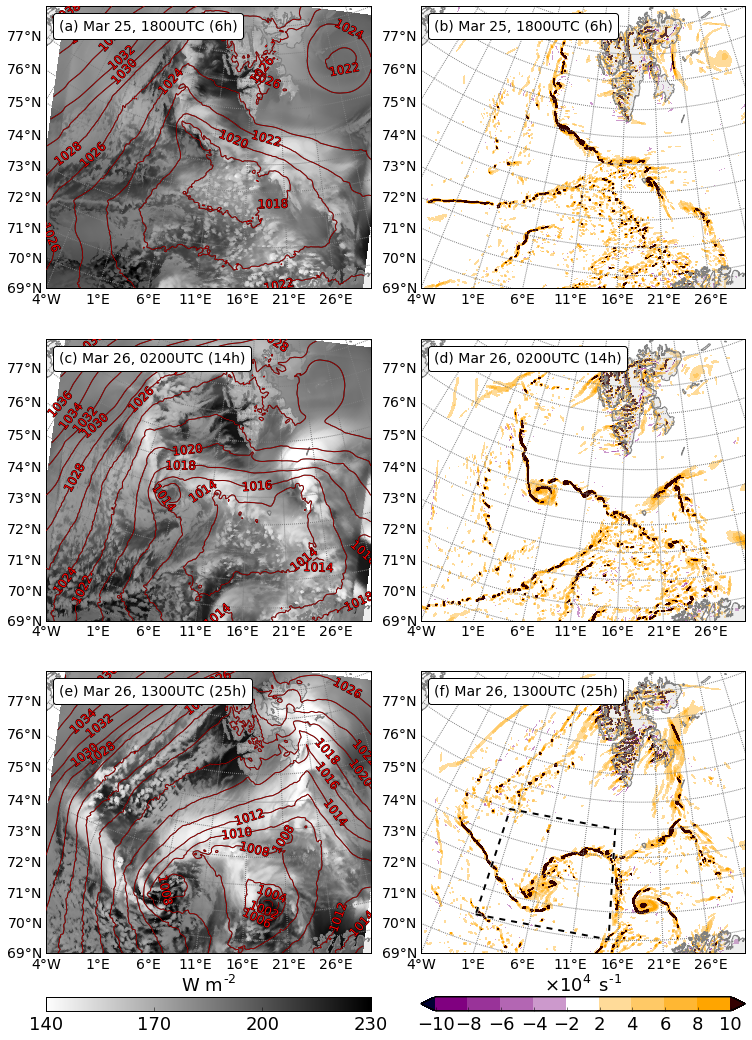

In [23]:
ncols = 2
nrows = len(times)
fig = plt.figure(figsize=(ncols*12,nrows*6))
grid = AxesGrid(fig, 111, nrows_ncols=(nrows, ncols), axes_pad=0.7, 
                cbar_location='bottom', cbar_mode='edge', cbar_pad=0.6)
axs = np.array(grid.axes_all).reshape(nrows,ncols)

for axrow, idt, lchar_pair in zip(axs, times, char_list_pairs):
    print(idt)
    fcst_len = (idt - fcst_init_dt).total_seconds()/3600
    # fcst_str = '\n{fcst_ref}UTC+{fcst_len:.0f}h'.format(fcst_ref=fcst_init_dt.strftime('%b %d %H%M'), fcst_len=fcst_len)
    fcst_str = ' ({fcst_len:.0f}h)'.format(fcst_len=fcst_len)
    
    iax = axrow[0]
    # OLR & SLP
    model_lw = lw_toa.extract(iris.Constraint(time=umu.nearest_tval(lw_toa, idt)))
    model_slp = slp.extract(iris.Constraint(time=umu.nearest_tval(slp, idt)))
    bm = mymap.make_map(ax=iax, **mapkw_large)
    c1 = bm.pcolormesh(lon2d, lat2d, model_lw.data, rasterized=True, **pcolkw_um)
    cc = bm.contour(lon2d, lat2d, model_slp.data/100., p_clevs, colors='r',linewidths=0.5, latlon=True, zorder=5)
    clbls = plt.clabel(cc, inline=1, inline_spacing=30, fmt='%1.0f', fontsize=12, colors='r')
    plt.setp(cc.collections, path_effects=pe)
    plt.setp(clbls, path_effects=pe)
    
    cb1 = plt.colorbar(c1, cax=grid.cbar_axes[0], **cbarkw1)
    cb1.ax.tick_params(labelsize=18)
    cb1.ax.set_title('$W$ $m^{-2}$', fontsize=18)
    cb1.solids.set_edgecolor("face")
    txt = '({lab}) {dt}UTC{fcst_str}'.format(lab=lchar_pair[0],
                                             dt=idt.strftime('%b %d, %H%M'),
                                             fcst_str=fcst_str)
    at = AnchoredText(txt, prop=dict(size=14), frameon=True, loc=2)
    at.patch.set_boxstyle('round', pad=0., rounding_size=0.2)
    iax.add_artist(at)
    
    
    iax = axrow[1]
    # Vorticity
    u_cube = fplev_all.extract('x_wind', strict=True)
    v_cube = fplev_all.extract('y_wind', strict=True)
    w_cube = fplev_all.extract('lagrangian_tendency_of_air_pressure', strict=True)
    _lon2d, _lat2d = umu.unrotate_xy_grids(u_cube)
    u_cube = u_cube.extract(iris.Constraint(time=umu.nearest_tval(u_cube, idt))).extract(iris.Constraint(pressure=umu.nearest_plevel(u_cube, the_level)))
    v_cube = v_cube.extract(iris.Constraint(time=umu.nearest_tval(v_cube, idt))).extract(iris.Constraint(pressure=umu.nearest_plevel(v_cube, the_level)))
    w_cube = w_cube.extract(iris.Constraint(time=umu.nearest_tval(w_cube, idt))).extract(iris.Constraint(pressure=umu.nearest_plevel(w_cube, the_level)))
    u_cube, v_cube = umi.unrotate_uv(u_cube, v_cube)

    u = pvci.replace_lonlat_dimcoord_with_cart(u_cube, dx=um_res.to_flt())
    v = pvci.replace_lonlat_dimcoord_with_cart(v_cube, dx=um_res.to_flt())
    w = pvci.replace_lonlat_dimcoord_with_cart(w_cube, dx=um_res.to_flt())
    AF = pvci.AtmosFlow(u, v, w)
    
    bm = mymap.make_map(ax=iax, **mapkw_large)
    c2 = bm.contourf(_lon2d, _lat2d, AF.rel_vort.data*scl, **vo_kw)
    
    cb2 = plt.colorbar(c2, cax=grid.cbar_axes[1], **cbarkw2)
    cb2.ax.tick_params(labelsize=18)
    cb2.ax.set_title(r'$\times$'+misc.unit_format(scl, unit='s^{-1}'), fontsize=18)
    cb2.solids.set_edgecolor("face")
    txt = '({lab}) {dt}UTC{fcst_str}'.format(lab=lchar_pair[1],
                                             dt=idt.strftime('%b %d, %H%M'),
                                             fcst_str=fcst_str)
    at = AnchoredText(txt, prop=dict(size=14), frameon=True, loc=2)
    at.patch.set_boxstyle('round', pad=0., rounding_size=0.2)
    iax.add_artist(at)
    
    
p = bm.plot([mapkw['lon1'],mapkw['lon2'],mapkw['lon2'],mapkw['lon1'],mapkw['lon1']],
            [mapkw['lat1'],mapkw['lat1'],mapkw['lat2'],mapkw['lat2'],mapkw['lat1']],
            latlon=True, color='k', linewidth=2, linestyle='--', path_effects=[PathEffects.withStroke(linewidth=3, foreground='w')])

imgname = 'olr_slp_vort_{ymd}_{times}.{fmt}'.format(ymd=idt.strftime('%Y%m%d'), fmt=fmt,
                                                  times='_'.join(['{0}'.format(i.strftime('%H%M')) for i in times]))

# fig.subplots_adjust(hspace=0.0)
fig.savefig(os.path.join('figures', imgname), pad_inches=0.1, **svfigkw)